In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('full_data_labeled.csv')
data = data.drop(columns=['CI SCORE GLOVE','CI SCORE GLOVE 2','CI SCORE GLOVE 50','CI MEAN SCORES']).replace(np.nan,'None')
print(data.shape)

df = data.copy()
df['LabelEncoded'] = df['Label'].replace(['no','yes'],[0,1])
df = df.drop(columns=['Vulnerability Type(s)','Vulnerability Name','Kmeans_clusters','CI SCORE','Label'])

df = df[df['Authentication']!='Single system']
df = df[df['Access']!='Unknown']
df = df.reset_index().drop(columns=['level_0'])

print(df.shape)

numerical_cols = ['Score','Number Of Related Vulnerabilities']
categorical_cols = ['Access','Complexity', 'Authentication', 'Conf.', 'Integ.', 'Avail']
# categorical_cols = ['Vulnerability Type(s)', 'Vulnerability Name', 'Access',
#                     'Complexity', 'Authentication', 'Conf.', 'Integ.', 'Avail']
label = ['LabelEncoded']

ohe = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    df[numerical_cols]
],axis=1)

from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()
std_scaler = stdScaler.fit_transform(df[numerical_cols])
ohe_std_scaled = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    pd.DataFrame(std_scaler,columns=numerical_cols)
],axis=1)
# Scaling all features
std_scaler_all = stdScaler.fit_transform(ohe)
ohe_all_scaled = pd.DataFrame(std_scaler_all,columns=ohe.columns)

from sklearn.preprocessing import MinMaxScaler 
mnScaler = MinMaxScaler()
mn_scaler = mnScaler.fit_transform(df[numerical_cols])
ohe_mn_scaled = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    pd.DataFrame(mn_scaler,columns=numerical_cols)
],axis=1)
print(ohe_mn_scaled.shape)



from imblearn.over_sampling import RandomOverSampler
X = ohe_mn_scaled
y = df[label]
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)


from imblearn.over_sampling import KMeansSMOTE
X = ohe_mn_scaled
y = df[label]
kmsmote = KMeansSMOTE()
X_kmsmote, y_kmsmote = kmsmote.fit_resample(X, y)


from imblearn.over_sampling import SMOTE
X = ohe_mn_scaled
y = df[label]
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)


(61698, 14)
(52634, 10)
(52634, 19)


In [3]:
print(y.value_counts())
print(y_ros.value_counts())
print(y_kmsmote.value_counts())
print(y_smote.value_counts())

LabelEncoded
1               43818
0                8816
Name: count, dtype: int64
LabelEncoded
0               43818
1               43818
Name: count, dtype: int64
LabelEncoded
0               43819
1               43818
Name: count, dtype: int64
LabelEncoded
0               43818
1               43818
Name: count, dtype: int64


# Models

In [4]:

from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

# Classification models :
from sklearn.neighbors import NearestCentroid # Test Score: 0.91  # Tuning: (shrink_threshold=0.3) = 0.92
from sklearn.naive_bayes import MultinomialNB # Test Score: 0.94  # Tuning: (alpha=10, fit_prior=False) = 0.95
from sklearn.naive_bayes import BernoulliNB # Test Score: 0.90    # Tuning: 0.99 overtif so use default
from sklearn.naive_bayes import ComplementNB # Test Score: 0.95   # Tuning: no effect so use default
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # Test Score: 0.72 # Tuning: (reg_param=0.1, store_covariance=True) = 0.95

from sklearn.naive_bayes import CategoricalNB # Test Score: 0.90
from sklearn.svm import NuSVC # Test Score: 0.91 - exe:7min


In [21]:

def train_model(X,Y,model):
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=2)
    cv = ShuffleSplit(test_size=0.2)
    cv_results = cross_validate(model,X=X_train,y=y_train,cv=cv,return_train_score=True, error_score='raise')
    print("Train Score:", f"{cv_results['train_score'].mean():.4f}")
    
    cross_val_scores = cross_val_score(model,X=X_train,y=y_train, cv=cv)
    print("Mean CV Score:", f"{cross_val_scores.mean():.4f}")
    
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print("Train Score:", f"{train_score:.4f}")
    print("Test Score:", f"{test_score:.4f}")
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(f"{accuracy_score(y_test,y_pred):.4f}")
    

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - OverSampling')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Class 0', 'Class 1'])
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # Display confusion matrix values
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='black')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()




## Over Sampling


Train Score: 0.9860
Mean CV Score: 0.9857
Train Score: 0.9862
Test Score: 0.9839
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8662
           1       1.00      0.97      0.98      8866

    accuracy                           0.98     17528
   macro avg       0.98      0.98      0.98     17528
weighted avg       0.98      0.98      0.98     17528

[[8634   28]
 [ 254 8612]]
0.9839


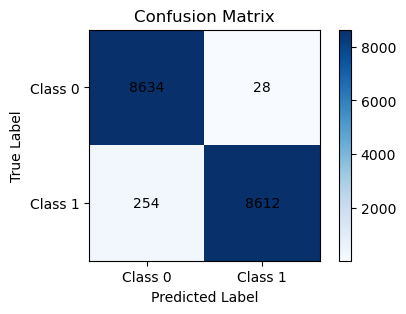

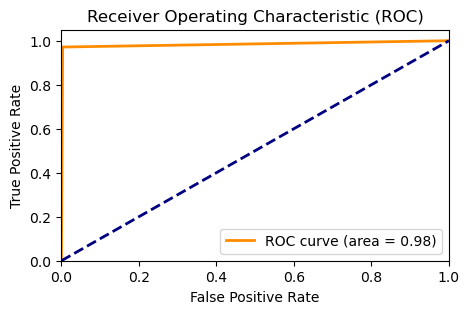

In [6]:

# Classification models :
from sklearn.neighbors import NearestCentroid # Test Score: 0.91  # Tuning: (shrink_threshold=0.3) = 0.92
from sklearn.naive_bayes import MultinomialNB # Test Score: 0.94  # Tuning: (alpha=10, fit_prior=False) = 0.95
from sklearn.naive_bayes import BernoulliNB # Test Score: 0.90    # Tuning: 0.99 overtif so use default
from sklearn.naive_bayes import ComplementNB # Test Score: 0.95   # Tuning: no effect so use default
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # Test Score: 0.72 # Tuning: (reg_param=0.1, store_covariance=True) = 0.95

from sklearn.naive_bayes import CategoricalNB # Test Score: 0.90
from sklearn.svm import NuSVC # Test Score: 0.91 - exe:7min


# RandomOverSampling
train_model(
    X = X_kmsmote,
    Y = y_kmsmote,
    model = NearestCentroid()
    )


## Hyperparams Tuning for each model

In [10]:

def tuning(X, Y, clf, param_grid):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
    grid_search = GridSearchCV(clf, param_grid, cv=10)
    grid_search.fit(X_train, y_train)
    
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best estimator:", grid_search.best_estimator_)
    print("Best Score:", grid_search.best_score_)

    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    
    

param_grid_NearestCentroid = {
    'shrink_threshold': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
}#Best estimator: NearestCentroid(shrink_threshold=0.3)

param_grid_MultinomialNB = {
    'alpha': [0, 0.1, 1.0, 2.0, 10, 100, 1000],
    'fit_prior': [True,False]
}#Best estimator: MultinomialNB(alpha=10, fit_prior=False)

param_grid_QuadraticDiscriminantAnalysis = {
    'reg_param': [0.0, 0.1, 0.2],
    'store_covariance': [True, False]
}#Best estimator: QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True)



# X_ros, y_ros
# X_kmsmote, y_kmsmote
# X_smote, y_smote

# Before Tuning
# train_model(X = X_smote,
#             Y = y_smote,
#             model = NearestCentroid())
# print('\n=========\tAfter Tuning\t==========\n')
# # After Tuning
# tuning(X = X_smote,
#        Y = y_smote,
#        clf = NearestCentroid(),
#        param_grid = param_grid_NearestCentroid)


In [11]:

from sklearn.ensemble import VotingClassifier

nc_clf = NearestCentroid(shrink_threshold=0.3)
mulnb_clf = MultinomialNB(alpha=10, fit_prior=False)
qda_clf = QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True)
bernb_clf = BernoulliNB()
comnb_clf = ComplementNB()

# NN_clf = keras.Sequential([
#     keras.layers.Dense(1,input_shape=(X_rus.shape[1],),activation='sigmoid')
# ]).compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# NN_clf.fit(x_train, y_train, epochs=3)


voting_clf = VotingClassifier([
    ('nc_clf',nc_clf),
    ('mulnb_clf',mulnb_clf),
    ('qda_clf',qda_clf),
    ('bernb_clf',bernb_clf),
    ('comnb_clf',comnb_clf),
])

# X_ros, y_ros
# X_kmsmote, y_kmsmote
# X_smote, y_smote

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2)
nc_clf.fit(X_train,y_train)
mulnb_clf.fit(X_train,y_train)
qda_clf.fit(X_train,y_train)
bernb_clf.fit(X_train,y_train)
comnb_clf.fit(X_train,y_train)

print("nc_clf : ",nc_clf.score(X_test,y_test))
print("mulnb_clf : ",mulnb_clf.score(X_test,y_test))
print("qda_clf : ",qda_clf.score(X_test,y_test))
print("bernb_clf : ",bernb_clf.score(X_test,y_test))
print("comnb_clf : ",comnb_clf.score(X_test,y_test))
print("\n=================================")


voting_clf.fit(X_train,y_train)
print("voting_clf trainig : ",voting_clf.score(X_train,y_train))
y_pred = voting_clf.predict(X_test)
print("voting_clf testing: ",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))



nc_clf :  0.9782633500684619
mulnb_clf :  0.9828845276129621
qda_clf :  0.984481971702419
bernb_clf :  0.9824281150159745
comnb_clf :  0.9828845276129621

voting_clf trainig :  0.9825982769441434
voting_clf testing:  0.9828845276129621
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8702
           1       0.98      0.98      0.98      8826

    accuracy                           0.98     17528
   macro avg       0.98      0.98      0.98     17528
weighted avg       0.98      0.98      0.98     17528



Train Score: 0.9830
Mean CV Score: 0.9830
Train Score: 0.9829
Test Score: 0.9816
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8673
           1       0.98      0.98      0.98      8855

    accuracy                           0.98     17528
   macro avg       0.98      0.98      0.98     17528
weighted avg       0.98      0.98      0.98     17528

[[8514  159]
 [ 163 8692]]
0.9816


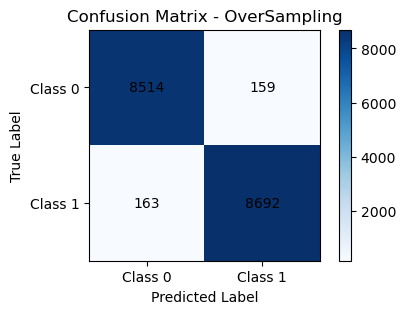

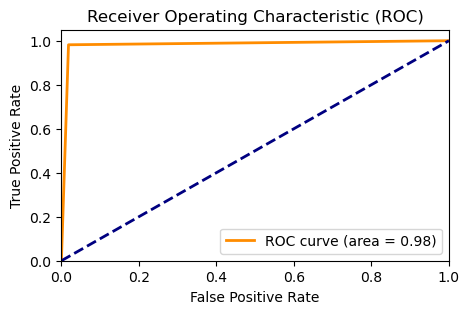

In [22]:

# X_ros, y_ros
# X_kmsmote, y_kmsmote
# X_smote, y_smote

train_model(
    X = X_smote,
    Y = y_smote,
    model = voting_clf
    )


#

# Compare Models

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


nc_clf = NearestCentroid(shrink_threshold=0.3)
mulnb_clf = MultinomialNB(alpha=10, fit_prior=False)
qda_clf = QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True)
lda_clf = LinearDiscriminantAnalysis()
bernb_clf = BernoulliNB()
comnb_clf = ComplementNB()
svc_clf = SVC()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
voting_clf = VotingClassifier([
        ('nc_clf',nc_clf),
        ('mulnb_clf',mulnb_clf),
        ('qda_clf',qda_clf),
        ('bernb_clf',bernb_clf),
        ('comnb_clf',comnb_clf),
    ])


# Create a list of classifiers
classifiers = [
    ('NearestCentroid', nc_clf),
    ('MultinomialNB', mulnb_clf),
    ('QuadraticDiscriminantAnalysis', qda_clf),
    ('LinearDiscriminantAnalysis', lda_clf),
    ('BernoulliNB', bernb_clf),
    ('ComplementNB', comnb_clf),
    ('SVC', svc_clf),
    ('KNeighborsClassifier', knn_clf),
    ('DecisionTreeClassifier', dt_clf),
    ('LogisticRegression', lr_clf),
    ('RandomForestClassifier', rf_clf),
    ('VotingClassifier', voting_clf),
]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=99)


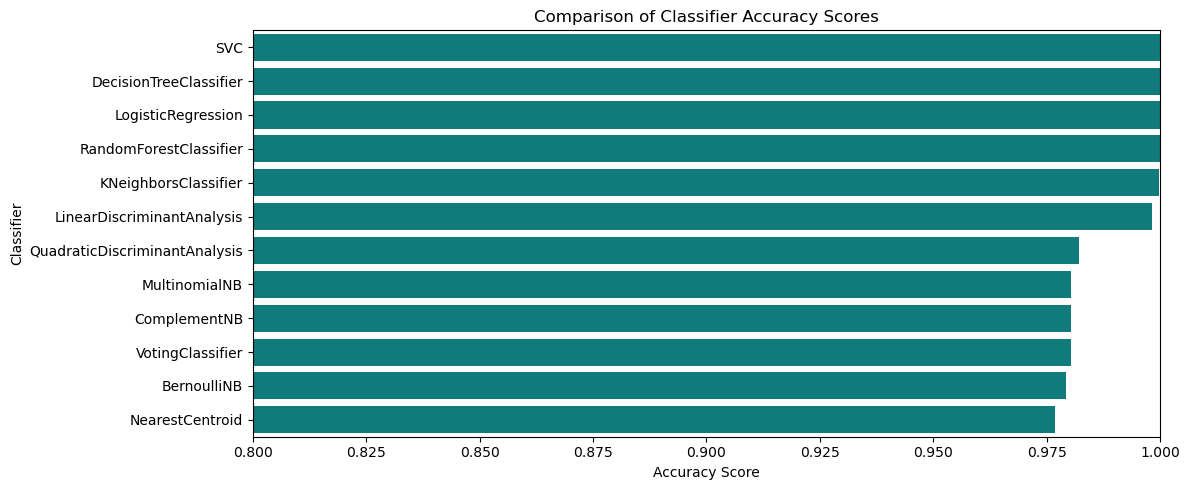

In [12]:


# Train and evaluate each classifier
accuracy_scores = []
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append({'Classifier': name, 'Accuracy': accuracy})

# Create a DataFrame to store the results
results_df = pd.DataFrame(accuracy_scores)

# Sort the DataFrame by accuracy score
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Create a horizontal bar plot to compare accuracy scores
plt.figure(figsize=(12, 5))
sns.barplot(x='Accuracy', y='Classifier', data=results_df, color='darkcyan')
plt.xlabel('Accuracy Score')
plt.ylabel('Classifier')
plt.title('Comparison of Classifier Accuracy Scores')
plt.xlim(0.8, 1.0)  # Set the x-axis range
plt.tight_layout()
plt.show()
